# Setup

In [ ]:
# !pip install statsmodels
# !pip install pmdarima
# !pip install matplotlib
# !pip install seaborn
# # !pip install "black[jupyter]"
# !pip3 install statsforecast
# # !pip install prophet
# !pip install --upgrade plotly
# !pip install learntools


In [1]:
# basic
import sys
from datetime import date
import pandas as pd
import numpy as np
from numpy import inf
import time 
from datetime import datetime

# plotting
from matplotlib import pyplot, dates
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Smoothing & Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.tsa.ar_model import AR, ARResults, AutoReg, ar_select_order
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMAResults
from statsmodels.tsa.arima.model import  ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# prophet
import prophet

# forecast
from statsforecast import StatsForecast

# eval
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse, meanabs

# descriptive tests
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf


# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/Users/axiao/.pyenv/versions/3.8.18/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /Users/axiao/Desktop/Projects/projects/store_sales/data

holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
transactions = pd.read_csv('transactions.csv',index_col='date', parse_dates=True)
oil =  pd.read_csv('oil.csv',index_col='date', parse_dates=True)
stores = pd.read_csv('stores.csv')

train = pd.read_csv('train.csv', index_col='date', parse_dates=True)
train_engineered = pd.read_csv('train_engineered.csv', index_col='date', parse_dates=True)  # for re-run purposes
test = pd.read_csv('test.csv', index_col='date', parse_dates=True)

/Users/axiao/Desktop/Projects/projects/store_sales/data


# NA Handling

In [3]:
dfs = {
    'holidays_events':holidays_events,
    'transactions':transactions,
    'oil':oil,
    'stores':stores,
    'train':train,
    'test':test
}

for k,v in dfs.items():
  if v.isna().sum().any():
    print(f"NAs exist in {k}")

NAs exist in oil


## `oil`

In [4]:
oil['interpolated_price']= oil['dcoilwtico'].interpolate(method='linear')
oil[oil['interpolated_price'].isna()] # check for NAs again

,dcoilwtico,interpolated_price
date,,
2013-01-01,NaN,NaN


In [5]:
oil['interpolated_price'] =oil['interpolated_price'].fillna(method='bfill')
oil[oil['interpolated_price'].isna()] # check for NAs again

,dcoilwtico,interpolated_price
date,,


In addition, the `oil` table doesn't have a pirce available for every date in the range.
We also use linear regression to extrapolate dates where price isn't available.

In [6]:
# target list, ranging from min train date to max test date
dates_lst = [x for x in pd.date_range(train.index.min().date(), test.index.max().date(), freq='1D').date]
# list of dates in oil date index to scan
scanning_lst = [item.date() for item in oil.index.unique().tolist()]

# use two pointers to find the dates in oil that are missing in the date range of interest
left = 0
right = len(dates_lst)-1
res_lst = []

while left < right:
  if dates_lst[left] not in scanning_lst:
    res_lst.append(dates_lst[left])
  if dates_lst[right] not in scanning_lst:
    res_lst.append(dates_lst[right])
  left += 1
  right -= 1

# convert list into pd date time index
res_lst = pd.DatetimeIndex(res_lst)

add the missing dates back to `oil` index

In [7]:
# create a df for the missing rows
missing_rows = {
    'date': res_lst,
    'dcoilwtico': [np.nan] * len(res_lst),
    'interpolated_price': [np.nan] * len(res_lst)
}

missing_rows_df = pd.DataFrame(missing_rows).set_index('date')

# concat this df back to oil
oil = pd.concat([missing_rows_df, oil], axis=0)

# sort order
oil = oil.sort_index()
oil.head()

,dcoilwtico,interpolated_price
date,,
2013-01-01,NaN,93.140000
2013-01-02,93.14,93.140000
2013-01-03,92.97,92.970000
2013-01-04,93.12,93.120000
2013-01-05,NaN,93.146667


use linear interpolation again to interpolate the missing data

In [8]:
oil['interpolated_price']= oil['interpolated_price'].interpolate(method='linear')
oil[oil['interpolated_price'].isna()] # check for NAs again

,dcoilwtico,interpolated_price
date,,


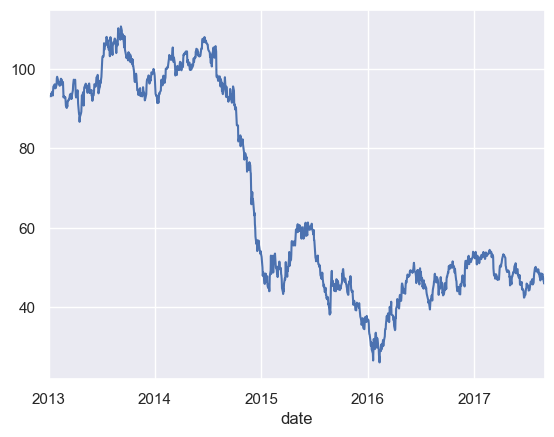

In [9]:
sns.set_theme()
oil['interpolated_price'].plot();

In [ ]:
# oil.to_csv('/store_sales/data/oil.csv')

# `holidays_events`

In [18]:
holidays_events2 = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)

Check if each locale name only has 1 holiday

In [19]:
tmp = holidays_events2.groupby(['date', 'locale', 'locale_name']).count()
tmp=tmp[tmp.type>1]

holidays_events2[holidays_events2.index.isin(tmp.reset_index()['date'])].iloc[:,:4]

,type,locale,locale_name,description
date,,,,
2012-12-24,Bridge,National,Ecuador,Puente Navidad
2012-12-24,Additional,National,Ecuador,Navidad-1
2012-12-31,Bridge,National,Ecuador,Puente Primer dia del ano
2012-12-31,Additional,National,Ecuador,Primer dia del ano-1
2014-12-26,Bridge,National,Ecuador,Puente Navidad
2014-12-26,Additional,National,Ecuador,Navidad+1
2016-05-01,Holiday,National,Ecuador,Dia del Trabajo
2016-05-01,Event,National,Ecuador,Terremoto Manabi+15
2016-05-07,Additional,National,Ecuador,Dia de la Madre-1


omit `additional` holidays

In [20]:
tmp = holidays_events2.groupby(['date','locale_name']).count()
tmp=tmp[tmp.type>1]

holidays_events2 = holidays_events2[
    ~(
        (holidays_events2.index.isin(tmp.reset_index()['date']))
        & (holidays_events2.type == 'Additional')
    )
]

# # check again
tmp = holidays_events2.groupby(['date','locale_name']).count()
tmp=tmp[tmp.type>1]
holidays_events2[holidays_events2.index.isin(tmp.reset_index()['date'])].iloc[:,:4]

,type,locale,locale_name,description
date,,,,
2016-05-01,Holiday,National,Ecuador,Dia del Trabajo
2016-05-01,Event,National,Ecuador,Terremoto Manabi+15
2016-05-08,Event,National,Ecuador,Terremoto Manabi+22
2016-05-08,Event,National,Ecuador,Dia de la Madre


need to do more data engineering for earthquake related days

In [21]:
holidays_events2['terremoto_manabi'] = 0
holidays_events2['terremoto_manabi'] = np.where(
    holidays_events2.description.str.contains('Terremoto Manabi')==True,
    1,
    0
)

# get the days we need to work with
tmp = holidays_events2.groupby(['date','locale_name']).count()
tmp=tmp[tmp.type>1]

# drop
holidays_events2 = holidays_events2[
    ~(
        (holidays_events2.index.isin(tmp.reset_index()['date'])) 
        & (holidays_events2.description.str.contains('Terremoto Manabi'))
    )]


# check again
tmp = holidays_events2.groupby(['date','locale_name']).count()
tmp=tmp[tmp.type>1]
holidays_events2[holidays_events2.index.isin(tmp.reset_index()['date'])].iloc[:,:4]
# holidays_events2.shape


,type,locale,locale_name,description
date,,,,


In [17]:
holidays_events2[holidays_events2.index=='2016-11-06']

,type,locale,locale_name,description,transferred,terremoto_manabi
date,,,,,,
2016-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False,0


# Joining Tables

## `stores` & `oil_price`

In [22]:
# preserve the train index
train_index_lst = train.index.tolist()
train_index = {
    'date':train_index_lst
}
train_index_df = pd.DataFrame(train_index)

# join train and stores
tmp1 = train.merge(
    stores,
    how='left',
    left_on=['store_nbr'],
    right_on=['store_nbr']
)

# add timestamp back
tmp1 = pd.concat([tmp1, train_index_df], axis=1)

# set index
tmp1 = tmp1.set_index('date')

# join with oil
tmp2 = tmp1.merge(
    oil['interpolated_price'],
    how='left',
    right_index=True,
    left_index=True
).rename(
    columns={
        'interpolated_price':'oil_price',
        'type':'store_type',
        'cluster':'store_cluster'
    }
)
len(tmp2)

3000888

In [23]:
test = pd.read_csv('train.csv', index_col='date', parse_dates=True)
test.shape

(3000888, 5)

In [24]:
tmp2.head()

,id,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,oil_price
date,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,1,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,2,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,3,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14
2013-01-01,4,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14


## `holidays_events`

in the last section, we made sure that on the locale_name-date level, now there's only one event/holiday for each day.

Now we take another two steps to join holidays events to the `train` table:
- join all rows with natioanl events
- then join regional/local ones on the city names

In [25]:
national_holidays = holidays_events2[holidays_events2['locale']=='National'][['locale_name', 'description']]
national_holidays.rename(
    columns={'description':'national_holidays'},
    inplace=True
)

local_regional_holidays = holidays_events2[holidays_events2['locale']!='National'][['locale_name', 'description']]
local_regional_holidays.rename(
    columns={'description':'regional_local_holidays'},
    inplace=True
)

In [26]:
holidays_events2[holidays_events2.index=='holidays_events2']

,type,locale,locale_name,description,transferred,terremoto_manabi
date,,,,,,


In [27]:
local_regional_holidays[local_regional_holidays.index=='2016-11-06']

,locale_name,regional_local_holidays
date,,
2016-11-06,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo


### National Holidays

In [28]:
tmp2.shape

(3000888, 10)

In [29]:
tmp3 = tmp2.merge(
    national_holidays['national_holidays'],
    how='left',
    left_index=True,
    right_index=True
)
tmp3.shape

(3000888, 11)

### Local/ Regional Holidays

In [38]:
tmp4 = tmp3.reset_index().merge(
    local_regional_holidays.reset_index(),
    how='left',
    left_on=['date', 'city'],
    right_on=['date','locale_name']
)
tmp4.shape

(3000888, 14)

In [39]:
# tmp4.drop(columns=['locale_name'], inplace=True)
tmp4.set_index('date',inplace=True)
tmp4.shape

(3000888, 13)

sanity check if anything's missing

In [40]:
holidays_events2.shape[0] == national_holidays.shape[0] +local_regional_holidays.shape[0]

True

all 'in-region' local/regional holidays are added 


In [41]:
lst = tmp4[
    (tmp4.index.isin(local_regional_holidays.index))
    & (tmp4['regional_local_holidays'].isna())
    & (tmp4['city'] == tmp4['locale_name'])
].index.unique()

len(lst)

0

### Out-of-Region Holidays

*this is where the hiccup that was only discovered in the modeling section* - there're so many local/regional holidays not captured cause there was no corresponding store in the city

In [42]:
tmp4[
    (tmp4.index.isin(local_regional_holidays.index))
    & (tmp4['regional_local_holidays'].isna())
    & (tmp4['city'] != tmp4['locale_name'])
].index.unique()

DatetimeIndex(['2013-03-02', '2013-04-01', '2013-04-12', '2013-04-14',
               '2013-04-21', '2013-05-12', '2013-06-23', '2013-06-25',
               '2013-07-03', '2013-07-23',
               ...
               '2017-04-21', '2017-05-12', '2017-06-23', '2017-06-25',
               '2017-07-03', '2017-07-23', '2017-07-24', '2017-07-25',
               '2017-08-05', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=119, freq=None)

In [43]:
holidays_events[holidays_events.index=='2013-03-02']

,type,locale,locale_name,description,transferred
date,,,,,
2013-03-02,Holiday,Local,Manta,Fundacion de Manta,False


add out of region holidays to the df too?

In [58]:
tmp4['out_of_region'] = np.nan
tmp4['out_of_region'] = np.where(
    (tmp4.index.isin(local_regional_holidays.index))
    & (tmp4['regional_local_holidays'].isna()),
    # & (tmp4['city'] != tmp4['locale_name']),
    1,
    tmp4['out_of_region'] 
)

tmp4[tmp4['out_of_region']==1].shape


(199815, 14)

In [47]:
tmp4.shape

(3000888, 14)

In [48]:
test = local_regional_holidays.merge(
    tmp4[['out_of_region']],
    how='left',
    left_index=True,
    right_index=True
)
test = test[test.out_of_region==1]
test.shape

(224565, 3)

In [59]:
out_of_region_holidays = local_regional_holidays[local_regional_holidays.index.isin(test.index)]

tmp = out_of_region_holidays.reset_index().groupby(['date']).count()
tmp = tmp[tmp['locale_name']>1]

out_of_region_holidays[out_of_region_holidays.index.isin(tmp.index)]['regional_local_holidays'].unique()

array(['Provincializacion de Imbabura', 'Fundacion de Machala',
       'Cantonizacion de Latacunga', 'Cantonizacion de El Carmen',
       'Fundacion de Santo Domingo'], dtype=object)

In [60]:
test = tmp4[tmp4['out_of_region']==1]
test.shape

(199815, 14)

In [63]:
test.head()

,id,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,oil_price,national_holidays,locale_name,regional_local_holidays,out_of_region
date,,,,,,,,,,,,,,
2013-03-02,106920,1,AUTOMOTIVE,1.0,0,Quito,Pichincha,D,13,90.516667,NaN,NaN,NaN,1.0
2013-03-02,106921,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,90.516667,NaN,NaN,NaN,1.0
2013-03-02,106922,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,90.516667,NaN,NaN,NaN,1.0
2013-03-02,106923,1,BEVERAGES,1221.0,0,Quito,Pichincha,D,13,90.516667,NaN,NaN,NaN,1.0
2013-03-02,106924,1,BOOKS,0.0,0,Quito,Pichincha,D,13,90.516667,NaN,NaN,NaN,1.0


In [61]:
tmp4.shape

(3000888, 14)

In [65]:
train_engineered = tmp4.copy()
# train_engineered.to_csv('../data/train_engineered.csv')

# Time Related

In [ ]:
# train_engineered = pd.read_csv('train_engineered.csv', index_col='date', parse_dates=True)

In [66]:
# # Time Related Features
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    return df


train_engineered.reset_index(inplace=True)
train_engineered = create_date_features(train_engineered)


# Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. 
# Supermarket sales could be affected by this.
train_engineered["wageday"] = pd.Series(np.where((train_engineered['is_month_end'] == 1) | (train_engineered["day_of_month"] == 15), 1, 0)).astype("int8")

# train_engineered.head(15)


Engineer some features for `holidays_events` and `transactions`, too.

In [67]:
# holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
holidays_events['day_of_year'] = holidays_events.reset_index().date.dt.dayofyear.astype("int16").tolist()
holidays_events['year'] = holidays_events.reset_index().date.dt.year.astype("int32").tolist()

# holidays_events = pd.read_csv('holidays_events.csv', index_col='date', parse_dates=True)
transactions['day_of_year'] = transactions.reset_index().date.dt.dayofyear.astype("int16").tolist()
transactions['year'] = transactions.reset_index().date.dt.year.astype("int32").tolist()
transactions['month'] = transactions.reset_index().date.dt.month.astype("int8").tolist()

In [ ]:
# train_engineered.to_csv('../data/train_engineered.csv')

# Dummify

dummify national and local/regional holiday column

In [68]:
national_dummy_df = pd.get_dummies(train_engineered['national_holidays'])
natioanl_dummy_lst = national_dummy_df.columns.tolist()   # save for later

regional_dummy_df = pd.get_dummies(train_engineered['regional_local_holidays'])
regional_dummy_lst = regional_dummy_df.columns.tolist()   # save for later

# put national & regional/local together
description_dummy_df = pd.concat([national_dummy_df, regional_dummy_df], axis=1)
description_dummy_lst = natioanl_dummy_lst.copy()
description_dummy_lst.extend(regional_dummy_lst)

In [69]:

# train_engineered['description'] = tmp['res3']
train_engineered = pd.concat([train_engineered, description_dummy_df], axis=1)

train_engineered[description_dummy_lst]=np.where(
    train_engineered[description_dummy_lst],
    1,
    0
)

Save `train` as `train_engineered`. We'll be using this df from this point on.

In [70]:
train_engineered.to_csv('../data/train_engineered.csv')